In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%; font-weight: bold}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 15pt; line-height: 140%;}</style>"))

In [2]:
import pickle
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing
import pandas as pd
import os
import time, os
import pymysql
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import ta
import warnings

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

warnings.filterwarnings(action='ignore')



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15,7)

Populating the interactive namespace from numpy and matplotlib


# 함수생성

## train data 생성 함수

In [3]:
def make_data_train_cci(trading=100000000, cci='_', days=10, label=0.02): 
    # traiding: 거래대금 임계값, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # trainX, trainY
    lst_trainX = []
    lst_trainY = []
    
    # next_change, code, date
    lst_nc = []  
    lst_cd = []
    lst_dt = []
    
    # database
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = 'stock_user', 
        passwd = 'bigdata', 
        db = 'refined_stock', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
       
    
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2017-01-01' AND '2020-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()

        
        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, cci_ = row[0].strftime('%Y%m%d'), row[4], row[5], row[40]
            # 거래대금, cci 범위 조건

            if (close * volume >= trading) & (cci_ <= cci):
                if i < (days-1):   # 예외 처리 
                    continue                               
                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_trainX.append(result)
                lst_trainY.append(y)
                lst_nc.append(row[7])
                lst_cd.append(code)
                lst_dt.append(date)
    
    return np.array(lst_trainX), np.array(lst_trainY), np.array(lst_nc), lst_cd, lst_dt 

## test data 생성 함수 

In [4]:
def make_data_test_cci(trading=100000000, cci='_', days=10, label=0.02): 
    # traiding: 거래대금 임계값, days: 일 수, label: next_chang 임계 값
    
    # 코드 리스트 
    IF=open("code_list.txt", 'r')
    lst_code = IF.readlines()
    
    # testX, testY
    lst_testX = []
    lst_testY = []
    
    # next_change
    lst_nc_test = []
    lst_cd_test = []
    lst_dt_test = []
    
    # database
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = 'stock_user', 
        passwd = 'bigdata', 
        db = 'refined_stock', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    col_scaling = ['Open', 'High', 'Low', 'Close', 'Trading', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_no_scaling = ['Change', 'Volume', 'MFI', 'ADI', 'OBV','CMF', 'FI', 'EOM, EMV', 
                      'VPT', 'NVI', 'ATR', 'UI', 'ADX', '-VI', '+VI', 'TRIX', 'MI', 
                      'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                       'WR', 'AO', 'ROC', 'PPO', 'PVO']
    
    
    for line in tqdm(lst_code): 
        code = line.strip()
        sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date BETWEEN '2021-01-01' AND '2021-12-31'
                    '''.format(code)

        stock = pd.read_sql(sql=sql_query, con=db_dsml)
        stock['BeforeClose'] = stock['Close'].shift(1) # 전날 종가 컬럼 추가
        stock.dropna(inplace=True) # nan 제거 
        lst_stock = stock.values.tolist()
               
        
        # scaling 필요 컬럼: 전날 종가로 나누어 스케일링
        stock['Trading'] = stock['Close'] * stock['Volume'] # 거래대금 컬럼 추가 
        scale_stock = stock[col_scaling].apply(lambda x: x/stock['BeforeClose'])
        lst_scale = scale_stock.values.tolist()

        # sclaling 필요x 컬럼 
        no_scale_stock = stock[col_no_scaling]
        lst_no_scale = no_scale_stock.values.tolist()        
        
        for i, row in enumerate(lst_stock): 
            date, close, volume, cci_ = row[0].strftime('%Y%m%d'), row[4], row[5], row[40]
            # 거래대금, cci 범위 조건
            if (close * volume >= trading) & (cci_ <= cci) :
                if i < (days-1):   # 예외 처리 
                    continue                               

                result=[]
                for row2, row3 in zip(lst_scale[i-(days-1):i+1], lst_no_scale[i-(days-1):i+1]):  # scaling, no scaling 
                    result += row2+row3 # scaling + no scaling                 
                y = int(row[7]>=label) # next change 사용   
                
                lst_testX.append(result)
                lst_testY.append(y)
                lst_nc_test.append(row[7])
                lst_cd_test.append(code)
                lst_dt_test.append(date)
    
    return np.array(lst_testX), np.array(lst_testY), np.array(lst_nc_test), lst_cd_test, lst_dt_test

## 평가지표 함수

In [5]:
def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=25)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

# CCI  ~ -100

- 보조지표 cci가 20일 이동 평균선에서 극단적으로 떨어져 있는 과매도 구간을 필터링

## 데이터 생성

In [6]:
trainX, trainY, lst_nc, lst_cd, lst_dt = make_data_train_cci(trading=100000000, cci=-100, days=10, label=0.02)
testX, testY, lst_nc_test, lst_cd_test, lst_dt_test = make_data_test_cci(trading=100000000, cci=-100, days=10, label=0.02)

100%|███████████████████████████████████████| 1561/1561 [00:50<00:00, 30.85it/s]


In [7]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(269977, 560)
(269977,)
(73435, 560)
(73435,)


## PARAMETER

[22:18:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


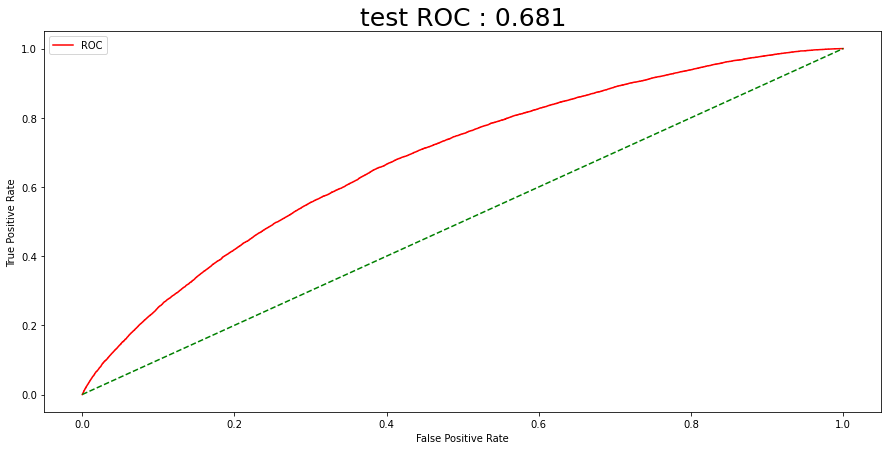

train_f1 score:  0.4158161346996534
test_f1 score:  0.39418199302800816 

train_recall score:  0.6024046270253139
test_recall score:  0.5808828739460072 

train_pre score:  0.31748003549245785
test_pre score:  0.29830434466196054 

train acc score:  0.683473036592006
test acc score:  0.6568529992510383 



In [8]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,   ### max_depth=5 일때는 ROC 0.678
                   n_estimators=800,
                   ) # 임의의 값 (튜닝값 x)

xgb_model.fit(trainX, trainY)

train_prob = xgb_model.predict_proba(trainX)[:, 1]
train_pred = xgb_model.predict(trainX)
test_prob = xgb_model.predict_proba(testX)[:, 1]
test_pred = xgb_model.predict(testX)

plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)

### 모델 저장 

In [9]:
import pickle
pickle.dump(xgb_model, open('xgb.model', 'wb'))

--------

### 모델 로드 

In [10]:
xgb_model = pickle.load(open('xgb.model', 'rb'))

train_prob = xgb_model.predict_proba(trainX)[:, 1]
train_pred = xgb_model.predict(trainX)
test_prob = xgb_model.predict_proba(testX)[:, 1]
test_pred = xgb_model.predict(testX)

# Shap Value

In [11]:
# 컬럼 리스트 생성
lst_col_info = []

for day in range(9, -1, -1): 
    lst_col_info += 'D-{0}_Open,D-{0}_High,D-{0}_Low,D-{0}_Close,D-{0}_Trading,D-{0}_MA5,D-{0}_MA20,D-{0}_MA60,D-{0}_MA120,D-{0}_VMAP,D-{0}_BHB,D-{0}_BLB,D-{0}_KCH,D-{0}_KCL,D-{0}_KCM,D-{0}_DCH,D-{0}_DCL,D-{0}_DCM,D-{0}_SMA,D-{0}_EMA,D-{0}_WMA,D-{0}_Ichimoku,D-{0}_Parabolic SAR,D-{0}_KAMA,D-{0}_MACD,D-{0}_Change,D-{0}_Volume,D-{0}_MFI,D-{0}_ADI,D-{0}_OBV,D-{0}_CMF,D-{0}_FI,D-{0}_EOM_EMV,D-{0}_VPT,D-{0}_NVI,D-{0}_ATR,D-{0}_UI,D-{0}_ADX,D-{0}_-VI,D-{0}_+VI,D-{0}_TRIX,D-{0}_MI,D-{0}_CCI,D-{0}_DPO,D-{0}_KST,D-{0}_STC,D-{0}_RSI,D-{0}_SRSI,D-{0}_TSI,D-{0}_UO,D-{0}_SR,D-{0}_WR,D-{0}_AO,D-{0}_ROC,D-{0}_PPO,D-{0}_PVO'.format(day).split(',')

In [12]:
##### train
df_trainX = pd.DataFrame(trainX)
df_trainX.columns = lst_col_info
df_trainY = pd.DataFrame(trainY)

##### test 
df_testX = pd.DataFrame(testX)
df_testX.columns = lst_col_info
df_testY = pd.DataFrame(testY)

df_trainX.head()

,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,D-9_TSI,D-9_UO,...,D-0_MA20,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
0,0.991238,1.004381,0.971522,0.980285,140309.140197,0.984885,0.943045,0.936528,0.995007,0.969697,1.000252,0.885838,0.974297,0.913180,0.943739,1.018620,0.883899,0.966594,0.955458,0.962009,0.975563,0.949343,0.963987,0.952518,0.018494,-0.019715,143131.0,79.960004,1.916877e+06,21657252.0,0.048163,1.482464e+07,-2.934375e+07,-179.811076,785.799290,300.291186,1.547914,25.775944,0.848039,1.122549,0.192263,24.466751,129.387084,-110.0,61.012976,99.999991,61.431919,0.524718,22.343847,47.311672,...,1.031353,0.995549,1.059598,1.053275,1.089167,0.973539,1.067745,0.999980,1.033863,1.094118,0.982353,1.030588,1.041765,1.025502,1.021098,1.027941,1.076619,1.017027,0.004102,-0.008235,55021.0,64.019560,1.777652e+06,21391456.0,-0.052969,-8.964902e+05,-2.180985e+07,-347.967891,755.508045,286.119975,3.665463,22.349526,1.041162,0.958838,0.214308,24.723678,-108.760852,263.5,63.347569,6.250000,40.723504,0.000000,5.486901,35.175106,8.421053,-91.578947,86.911765,-7.362637,0.401602,-13.360869
1,1.019084,1.019084,0.938931,0.946565,690931.786260,0.964885,0.889427,0.787226,0.717487,0.930415,0.987601,0.791254,0.951031,0.832481,0.891756,1.064885,0.818321,0.958015,0.915712,0.923102,0.946650,0.939885,0.984733,0.901049,0.045323,-0.053435,729936.0,84.334086,2.374815e+06,40575321.0,-0.020050,4.699603e+08,-2.517344e+07,-3035.276486,605.945678,800.027072,2.315196,58.171577,0.838710,1.102151,0.688982,26.925425,122.307724,48.5,178.444216,91.530287,61.395953,0.267015,31.436250,43.932832,...,1.067857,0.955640,0.861265,1.097944,1.168896,0.966818,1.143452,0.999256,1.071354,1.245536,0.977679,1.084821,1.080357,1.053321,1.042758,1.088170,1.196341,1.041862,0.013020,0.004464,519974.0,66.151552,1.649277e+06,38441327.0,-0.095754,-1.190999e+08,-1.538538e+07,-8007.251377,590.821692,745.664470,8.125746,49.445217,0.969582,0.958175,0.461769,25.818533,-105.780659,790.0,108.086846,0.821640,45.121178,0.022302,7.541308,40.870588,10.000000,-90.000000,43.235294,-13.127413,1.251577,-3.674717
2,0.991935,1.040323,0.987903,1.004032,317878.620968,1.026613,0.945484,0.836371,0.760813,0.987418,1.049874,0.841094,1.010484,0.885484,0.947984,1.125000,0.864516,1.012097,0.972446,0.979647,1.005376,0.992944,1.040323,0.955047,0.046634,0.004032,316602.0,81.618263,2.253045e+06,40891923.0,-0.009864,4.050846e+08,-5.132627e+07,-37727.592773,608.389007,789.310853,2.668087,58.969698,0.925314,1.096698,0.702172,26.918130,89.489317,-124.0,180.317602,95.765143,61.860015,0.293784,30.169604,42.135508,...,1.060444,0.953763,0.859193,1.085628,1.166941,0.953948,1.128444,0.997778,1.063111,1.240000,0.973333,1.060000,1.062593,1.037738,1.022420,1.078889,1.186670,1.028793,0.006349,-0.022222,727215.0,54.036897,9.220624e+05,37714112.0,-0.080638,-1.280576e+08,0.000000e+00,-13839.020833,590.821692,713.831293,9.186040,47.007649,1.197183,0.953052,0.393823,25.747021,-103.614458,1170.0,90.738476,0.410820,42.403451,0.000000,3.945359,39.056401,1.960784,-98.039216,-168.382353,-13.725490,0.615608,-4.840261
3,1.000000,1.020080,0.979920,0.991968,350971.128514,1.012851,0.946787,0.837590,0.760281,0.986872,1.050114,0.843460,1.012035,0.886493,0.949264,1.120482,0.861044,1.008032,0.973561,0.97821

In [13]:
##### train
df_trainX_cd = df_trainX.copy()
df_trainX_cd['Code'] = lst_cd
df_trainX_cd['Date'] = lst_dt
df_trainX_cd['label'] = trainY
df_trainX_cd = df_trainX_cd[['Code', 'Date']+lst_col_info+['label']]


##### test
df_testX_cd = df_testX.copy()
df_testX_cd['Code'] = lst_cd_test
df_testX_cd['Date'] = lst_dt_test
df_testX_cd = df_testX_cd[['Code', 'Date']+lst_col_info]

df_trainX_cd.head()

,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,...,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO,label
0,050120,20170125,0.991238,1.004381,0.971522,0.980285,140309.140197,0.984885,0.943045,0.936528,0.995007,0.969697,1.000252,0.885838,0.974297,0.913180,0.943739,1.018620,0.883899,0.966594,0.955458,0.962009,0.975563,0.949343,0.963987,0.952518,0.018494,-0.019715,143131.0,79.960004,1.916877e+06,21657252.0,0.048163,1.482464e+07,-2.934375e+07,-179.811076,785.799290,300.291186,1.547914,25.775944,0.848039,1.122549,0.192263,24.466751,129.387084,-110.0,61.012976,99.999991,61.431919,0.524718,...,0.995549,1.059598,1.053275,1.089167,0.973539,1.067745,0.999980,1.033863,1.094118,0.982353,1.030588,1.041765,1.025502,1.021098,1.027941,1.076619,1.017027,0.004102,-0.008235,55021.0,64.019560,1.777652e+06,21391456.0,-0.052969,-8.964902e+05,-2.180985e+07,-347.967891,755.508045,286.119975,3.665463,22.349526,1.041162,0.958838,0.214308,24.723678,-108.760852,263.5,63.347569,6.250000,40.723504,0.000000,5.486901,35.175106,8.421053,-91.578947,86.911765,-7.362637,0.401602,-13.360869,0
1,050120,20170518,1.019084,1.019084,0.938931,0.946565,690931.786260,0.964885,0.889427,0.787226,0.717487,0.930415,0.987601,0.791254,0.951031,0.832481,0.891756,1.064885,0.818321,0.958015,0.915712,0.923102,0.946650,0.939885,0.984733,0.901049,0.045323,-0.053435,729936.0,84.334086,2.374815e+06,40575321.0,-0.020050,4.699603e+08,-2.517344e+07,-3035.276486,605.945678,800.027072,2.315196,58.171577,0.838710,1.102151,0.688982,26.925425,122.307724,48.5,178.444216,91.530287,61.395953,0.267015,...,0.955640,0.861265,1.097944,1.168896,0.966818,1.143452,0.999256,1.071354,1.245536,0.977679,1.084821,1.080357,1.053321,1.042758,1.088170,1.196341,1.041862,0.013020,0.004464,519974.0,66.151552,1.649277e+06,38441327.0,-0.095754,-1.190999e+08,-1.538538e+07,-8007.251377,590.821692,745.664470,8.125746,49.445217,0.969582,0.958175,0.461769,25.818533,-105.780659,790.0,108.086846,0.821640,45.121178,0.022302,7.541308,40.870588,10.000000,-90.000000,43.235294,-13.127413,1.251577,-3.674717,0
2,050120,20170519,0.991935,1.040323,0.987903,1.004032,317878.620968,1.026613,0.945484,0.836371,0.760813,0.987418,1.049874,0.841094,1.010484,0.885484,0.947984,1.125000,0.864516,1.012097,0.972446,0.979647,1.005376,0.992944,1.040323,0.955047,0.046634,0.004032,316602.0,81.618263,2.253045e+06,40891923.0,-0.009864,4.050846e+08,-5.132627e+07,-37727.592773,608.389007,789.310853,2.668087,58.969698,0.925314,1.096698,0.702172,26.918130,89.489317,-124.0,180.317602,95.765143,61.860015,0.293784,...,0.953763,0.859193,1.085628,1.166941,0.953948,1.128444,0.997778,1.063111,1.240000,0.973333,1.060000,1.062593,1.037738,1.022420,1.078889,1.186670,1.028793,0.006349,-0.022222,727215.0,54.036897,9.220624e+05,37714112.0,-0.080638,-1.280576e+08,0.000000e+00,-13839.020833,590.821692,713.831293,9.186040,47.007649,1.197183,0.953052,0.393823,25.747021,-103.614458,1170.0,90.738476,0.410820,42.403451,0.000000,3.945359,39.056401,1.960784,-98.039216,-168.382353,-13.725490,0.615608,-4.840261,0
3,050120,20170522,1.000000,1.020080,0.979920,0.991968,350971.128514,1.012851,0.946787,0.837590,0.760281,0.986872,1.050114,0.843460,1.012035,0.886493,0.949264,1.120482,0.861044,1.008032,0.973561,0.978213,1.003302,0.988956,1.036

# summary plot

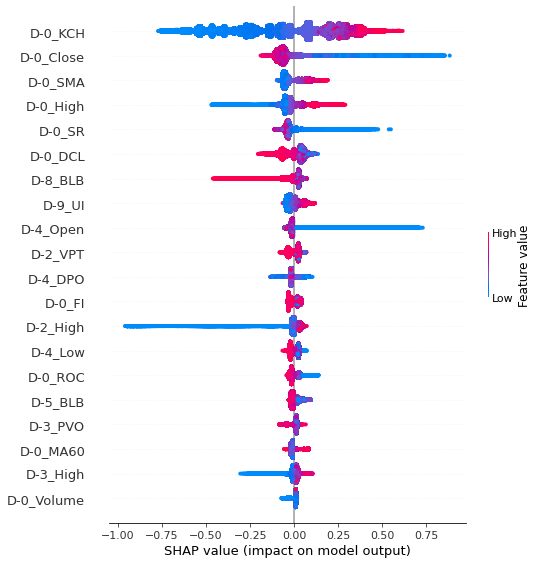

In [14]:
##### train
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(df_trainX)
shap.summary_plot(shap_values, df_trainX)

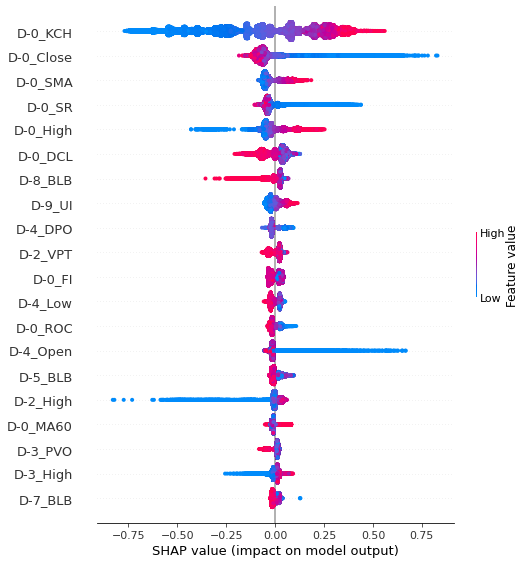

In [15]:
##### test
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values_test = explainer.shap_values(df_testX)
shap.summary_plot(shap_values_test, df_testX)

## shap_value 데이터프레임 생성 

In [16]:
##### train
df_shap = pd.DataFrame(shap_values)
df_shap.columns = lst_col_info

##### test
df_shap_test = pd.DataFrame(shap_values_test)
df_shap_test.columns = lst_col_info

#### df가 맞는지 확인  - 절댓값 씌운 후 컬럼 별 합 내림차순 정렬이 summary plot과 같은지 확인 

In [17]:
pd.DataFrame(df_shap.apply(lambda x: abs(x)).sum().sort_values(ascending=False)).head(10)

,0
D-0_KCH,70880.867188
D-0_Close,26787.449219
D-0_SMA,14773.582031
D-0_High,14403.840820
D-0_SR,13907.189453
D-0_DCL,13431.515625
D-8_BLB,8770.682617
D-9_UI,8238.423828
D-4_Open,7172.552734
D-2_VPT,6958.154785


--------------

# Tree Plot 

- xgb model 의 max_deqpth를 3으로 지정 

## origin data
- shap value tree plot과 비교를 위하여 생성

In [18]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


<AxesSubplot:>

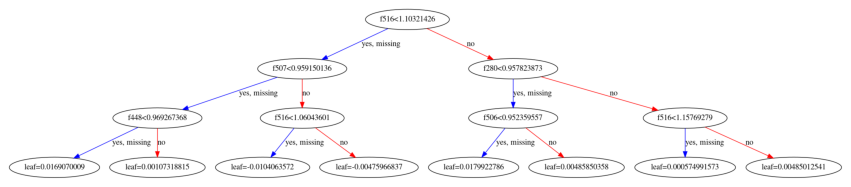

In [19]:
from xgboost import plot_tree

plot_tree(xgb_model)

- 가장 오른쪽 조건 ((['D-0_KCH']>1.1032) & (['D-4_Open']>0.9578) & (['D-0_KCH']>1.1577))의 데이터 확인

In [21]:
print('total label: ', len(trainY[(df_trainX['D-0_KCH']>1.1032) & (df_trainX['D-4_Open']>0.9578) & (df_trainX['D-0_KCH']>1.1577)]))
print('trainY label 1: ', (trainY[(df_trainX['D-0_KCH']>1.10321) & (df_trainX['D-4_Open']>0.9578) & (df_trainX['D-0_KCH']>1.1577)]==1).sum())
print('train pred label 1 (xgb pred): ', (train_pred[(df_trainX['D-0_KCH']>1.1032) & (df_trainX['D-4_Open']>0.9578) & (df_trainX['D-0_KCH']>1.1577)]==1).sum())

total label:  55425
trainY label 1:  16119
train pred label 1 (xgb pred):  48114


In [22]:
df_cd =  df_trainX_cd[(df_trainX['D-0_KCH']>1.1032) & (df_trainX['D-4_Open']>0.9578) & (df_trainX['D-0_KCH']>1.1577)]
df_cd

,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,...,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO,label
4,050120,20170523,1.004049,1.004049,0.955466,0.979757,3.270743e+05,1.010526,0.958907,0.848691,0.768900,1.001767,1.059334,0.858480,1.025007,0.897881,0.961444,1.129555,0.886640,1.016194,0.985155,0.985153,1.007737,0.998381,1.044534,0.961769,0.040845,-0.020243,333832.0,79.287572,2.111520e+06,40204278.0,-0.004266,2.813582e+08,-6.290589e+07,-9599.604279,596.073440,756.599664,3.422168,58.913183,0.944715,1.065041,0.697805,26.792901,26.288515,-342.50,177.188436,52.584968,56.462246,0.000000,...,1.034679,0.932596,1.120711,1.279413,0.994144,1.215144,1.068990,1.142067,1.341346,0.995192,1.105769,1.112580,1.089224,1.061218,1.137019,1.267881,1.077159,-0.010669,0.009615,985008.0,23.688312,-8.618295e+05,37362959.0,-0.195730,-1.781785e+08,-9.771494e+06,-63410.278322,596.502669,707.844329,11.945406,40.889785,1.167513,0.741117,0.230075,25.681454,-135.213965,627.50,39.798221,0.102705,38.186006,0.041239,-4.753380,32.124091,4.761905,-95.238095,-627.794118,-15.322581,-0.969999,0.192505,0
5,050120,20170524,0.991736,1.008264,0.966942,0.975207,3.370685e+05,1.009917,0.980785,0.869972,0.786970,1.028849,1.081234,0.880336,1.049904,0.918499,0.984201,1.152893,0.904959,1.037190,1.007576,1.000846,1.018733,1.019628,1.066116,0.981553,0.036183,-0.024793,345638.0,73.655205,1.904137e+06,39858640.0,-0.041915,2.263511e+08,-2.169900e+07,-15327.269984,596.073440,738.271116,4.323572,58.036123,1.063348,1.049774,0.675006,26.703127,-1.081324,-417.50,170.211627,26.292484,52.172434,0.000000,...,1.025444,0.924960,1.062289,1.281716,0.954665,1.199048,1.049619,1.124333,1.328571,0.929524,1.067143,1.081111,1.056757,1.022392,1.098095,1.239600,1.041689,-0.021241,-0.064762,2850709.0,9.662617,-3.305294e+06,34512250.0,-0.276796,-4.296505e+08,-1.311253e+07,-175146.113993,596.502669,717.284020,13.212393,39.194819,1.242518,0.681115,0.135831,25.579798,-162.232498,609.00,10.843892,0.051353,32.557557,0.000000,-9.887812,25.537981,1.671309,-98.328691,-851.352941,-21.124498,-1.970400,14.247029,0
6,050120,20170525,1.000000,1.063559,0.991525,1.025424,5.380788e+05,1.030508,1.009958,0.895932,0.809428,1.057793,1.108797,0.911118,1.083008,0.943856,1.013432,1.182203,0.927966,1.063559,1.037782,1.026158,1.038983,1.055085,1.093220,1.007047,0.034286,0.025424,524738.0,77.876771,1.873270e+06,40383378.0,-0.037874,2.165040e+08,2.834748e+07,4771.259420,596.073440,746.251751,4.768452,57.562692,0.921397,1.043668,0.647654,26.347093,20.251166,-417.50,167.745222,13.146242,55.789760,0.164944,...,1.097845,0.990597,1.114307,1.379046,0.996921,1.276544,1.113510,1.195027,1.420570,0.993890,1.141039,1.136032,1.112763,1.070627,1.174134,1.298914,1.100822,-0.029932,0.018330,1568244.0,9.238295,-3.662964e+06,36080494.0,-0.280069,-3.279456e+08,-4.179834e+06,-155871.528061,607.436527,706.763733,14.148805,37.620921,1.266015,0.688382,0.041312,25.449345,-141.935303,434.00,-13.390530,0.025676,35.277069,0.092808,-13.144026,26.302105,7.643312,-92.356688,-1027.617647,-19.028340,-2.619437,15.145628,0
7,050120,20170526,1.000000,1.045455,0.983471,1.020661,6.057726e+05,1.003306,0.990496,0.877741,0.791921,1.034121,1.081446,0.899545,1.063003,0.923747,0.993375,1.152893,0.909091,1.041322,1.017906,1.003

<AxesSubplot:xlabel='label', ylabel='count'>

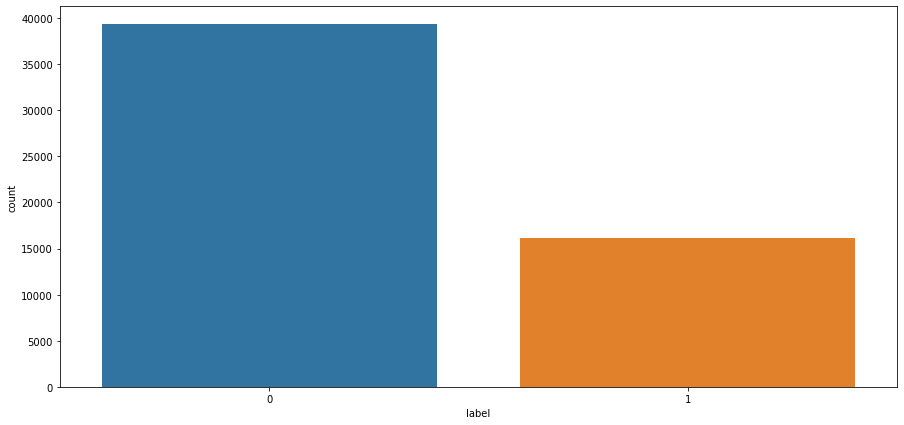

In [24]:
import seaborn as sns
sns.countplot(df_cd['label'])

In [25]:
#랜덤 2개 추출
r1,r2=random.choice(range(0,55425),2)
print(df_cd.iloc[r1,[0,1]])
print()
print(df_cd.iloc[r2,[0,1]]) 

Code      057030
Date    20200623
Name: 96961, dtype: object

Code      054780
Date    20201022
Name: 110762, dtype: object


---------

## shap value data

In [26]:
from xgboost import XGBClassifier

xgb_model_shap = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=800,
                   ) # 임의의 값 (튜닝값 x)

xgb_model_shap.fit(df_shap, trainY)

[22:55:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

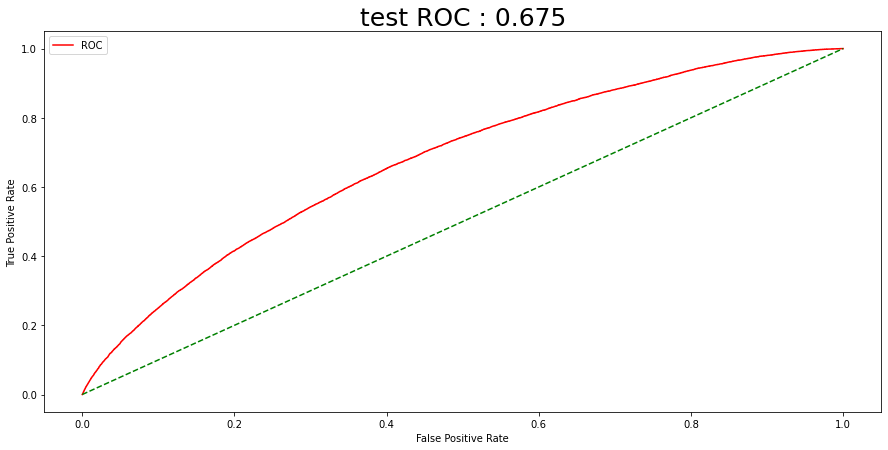

train_f1 score:  0.4293551260480439
test_f1 score:  0.38788380530327016 

train_recall score:  0.6014934833419165
test_recall score:  0.5643732728689861 

train_pre score:  0.33382068419664057
test_pre score:  0.2954815254488797 

train acc score:  0.7010115676520593
test acc score:  0.6576700483420712 



In [27]:
train_prob = xgb_model_shap.predict_proba(df_shap)[:, 1]
train_pred = xgb_model_shap.predict(df_shap)
test_prob = xgb_model_shap.predict_proba(df_shap_test)[:, 1]
test_pred = xgb_model_shap.predict(df_shap_test)

plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)

<AxesSubplot:>

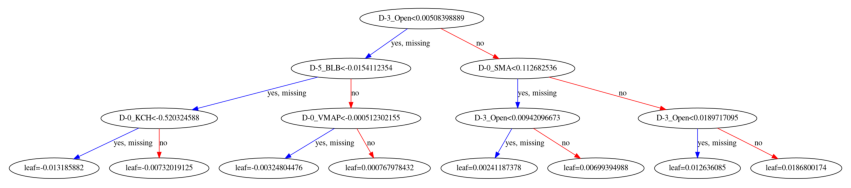

In [28]:
from xgboost import plot_tree

plot_tree(xgb_model_shap)

- 가장 오른쪽 조건 ((df_shap['D-3_Open']>0.0051) & (df_shap['D-0_SMA']>0.1127) & (df_shap['D-3_Open']>0.019)) 의 데이터 확인 

In [29]:
print('total label: ', len(trainY[(df_shap['D-3_Open']>0.0051) & (df_shap['D-0_SMA']>0.1127) & (df_shap['D-3_Open']>0.019)]))
print('trainY label 1: ', (trainY[(df_shap['D-3_Open']>0.0051) & (df_shap['D-0_SMA']>0.1127) & (df_shap['D-3_Open']>0.019)]==1).sum())
print('train pred label 1 (xgb pred): ', (train_pred[(df_shap['D-3_Open']>0.0051) & (df_shap['D-0_SMA']>0.1127) & (df_shap['D-3_Open']>0.019)]==1).sum())

total label:  3139
trainY label 1:  2765
train pred label 1 (xgb pred):  3132


In [30]:
df_shap_cd =  df_trainX_cd[(df_shap['D-3_Open']>0.0051) & (df_shap['D-0_SMA']>0.1127) & (df_shap['D-3_Open']>0.019)]
df_shap_cd

,Code,Date,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_Trading,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,D-9_BHB,D-9_BLB,D-9_KCH,D-9_KCL,D-9_KCM,D-9_DCH,D-9_DCL,D-9_DCM,D-9_SMA,D-9_EMA,D-9_WMA,D-9_Ichimoku,D-9_Parabolic SAR,D-9_KAMA,D-9_MACD,D-9_Change,D-9_Volume,D-9_MFI,D-9_ADI,D-9_OBV,D-9_CMF,D-9_FI,D-9_EOM_EMV,D-9_VPT,D-9_NVI,D-9_ATR,D-9_UI,D-9_ADX,D-9_-VI,D-9_+VI,D-9_TRIX,D-9_MI,D-9_CCI,D-9_DPO,D-9_KST,D-9_STC,D-9_RSI,D-9_SRSI,...,D-0_MA60,D-0_MA120,D-0_VMAP,D-0_BHB,D-0_BLB,D-0_KCH,D-0_KCL,D-0_KCM,D-0_DCH,D-0_DCL,D-0_DCM,D-0_SMA,D-0_EMA,D-0_WMA,D-0_Ichimoku,D-0_Parabolic SAR,D-0_KAMA,D-0_MACD,D-0_Change,D-0_Volume,D-0_MFI,D-0_ADI,D-0_OBV,D-0_CMF,D-0_FI,D-0_EOM_EMV,D-0_VPT,D-0_NVI,D-0_ATR,D-0_UI,D-0_ADX,D-0_-VI,D-0_+VI,D-0_TRIX,D-0_MI,D-0_CCI,D-0_DPO,D-0_KST,D-0_STC,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO,label
196,050120,20200319,0.987821,1.000000,0.951286,0.962111,405321.953992,0.966982,1.010284,1.103090,1.172982,0.975662,1.127774,0.892794,1.051376,0.971538,1.011457,1.100135,0.893099,0.949932,0.968313,0.980628,0.962652,0.976996,0.982902,0.967789,-0.040216,-0.037889,421284.0,22.109304,-5.102004e+08,928850253.0,-0.201947,-4.450549e+07,-8.972570e+06,-8843.083456,51.183512,328.429171,10.453356,36.228513,1.102000,0.826000,-0.576973,25.376019,-48.613377,244.00,-131.528578,84.482274,40.097056,0.771845,...,1.455640,1.588863,1.086495,1.544184,0.905154,1.331033,1.136704,1.233869,1.455577,0.812854,1.104915,1.151859,1.107269,1.018273,1.126654,1.196603,1.056951,-0.134243,-0.098299,2772888.0,42.630522,-5.154708e+08,921951744.0,-0.377412,-3.194807e+08,-3.214158e+07,-287319.677939,51.321021,543.801865,20.965045,47.490770,1.102723,0.707921,-1.031342,27.322714,-151.811957,731.50,-240.223195,7.453244e-01,20.613337,0.050235,-47.475724,29.899947,15.015974,-84.984026,-1782.500000,-32.627119,-10.812842,24.416193,1
198,050120,20200323,0.962963,1.000000,0.958519,0.983704,669145.754074,1.040000,1.086370,1.197827,1.277938,1.047567,1.218616,0.954124,1.135407,1.041185,1.088296,1.200000,0.958519,1.029630,1.037654,1.050193,1.032099,1.056296,1.098341,1.054895,-0.049452,-0.016296,680231.0,21.873986,-5.102920e+08,927695439.0,-0.210550,-6.430765e+07,-1.111387e+07,-35114.764913,51.183512,337.676173,11.554062,38.415041,1.198131,0.773832,-0.591617,25.037655,-119.940525,-453.00,-138.794332,46.096600,33.170396,0.463929,...,1.526915,1.681586,1.116530,1.639509,0.873999,1.365558,1.162332,1.263945,1.497984,0.866935,1.116935,1.142473,1.115900,1.015636,1.179435,1.179435,1.049298,-0.155403,-0.088710,794172.0,33.097518,-5.153112e+08,922049208.0,-0.254443,-2.638957e+08,-1.359907e+07,-34934.842564,48.631240,527.461812,24.577201,48.590709,1.238329,0.665848,-1.202680,28.065564,-138.499533,876.50,-274.845634,1.863311e-01,22.017242,0.104401,-49.402044,32.068664,7.028754,-92.971246,-1872.470588,-38.836265,-12.223931,14.950380,1
392,095340,20200319,0.978102,0.989051,0.945255,0.978102,174850.437956,0.961314,0.981934,0.858431,0.789659,0.984411,1.097056,0.866812,1.045925,0.910523,0.978224,1.138686,0.839416,0.961679,0.976886,0.969802,0.959854,0.971715,1.026994,0.967538,0.018127,-0.021898,178765.0,42.247148,-1.451743e+06,11175281.0,0.156549,1.746889e+07,-1.342545e+08,-929.169451,298.628924,889.780453,9.218286,18.471364,1.106870,0.847328,0.439113,25.633410,-10.481100,897.50,114.702592,0.745701,53.498580,0.426403,...,1.593671,1.465597,1.420116,2.221673,0.948462,1.738761,1.448896,1.593829,1.966216,0.785135,1.308108,1.452027,1.331567,1.170721,1.363851,1.423948,1.174430,-0.182748,-0.200000,385867.0,31.431021,-2.593450e+06,7886733.0,-0.149344,-3.124208e+08,-6.228571e+08,-127155.768921,214.229168,1164.406715,27.735943,28.283973,1.210465,0.587791,-0.606417,26.785845,-191.397772,1770.50,-193.672679,1.456448e-03,20.176253,0.000000,-33.784823,31.294127,1.359703,-98.640297,-3925.794118,-53.015873,-12.068026,9.785814,1
394,095340,20200323,0.975806,1.040323,0.975806,1.040323,219305.201613,1.062903,1.088105,0.957728,0.877540,1.070211,1.205090,0.971120,1.161223,

<AxesSubplot:xlabel='label', ylabel='count'>

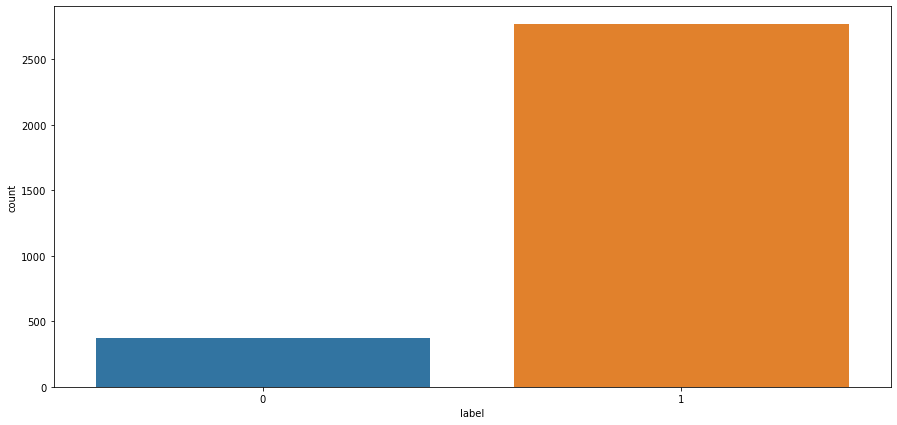

In [32]:
import seaborn as sns
sns.countplot(df_shap_cd['label'])

In [78]:
df_shap_cd['Date'].value_counts().head()  #2020년 3월에 많이 분포

20200319    969
20200323    902
20200324    736
20190807     99
20190806     36
Name: Date, dtype: int64

In [79]:
#랜덤 2개 추출
r1,r2=random.choice(range(0,3139),2)
print(df_shap_cd.iloc[r1,[0,1]])
print()
print(df_shap_cd.iloc[r2,[0,1]]) 

Code      078860
Date    20200324
Name: 87571, dtype: object

Code      137940
Date    20200311
Name: 42855, dtype: object
